In [1]:
import os
import sys
sys.path.append(os.path.abspath('..'))
from config import *

import random
import numpy as np
import torch
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# 演習：小麦穂検出

穂数や開花数、結実数などを数えることは、フェノタイピングにおいて欠かせない作業である。しかし、実験圃場全体を対象としたフェノタイピングには高いコストがかかる。そのため、現在では深層学習による画像認識を活用したフェノタイピングが一般的となっている。本節では、小麦の穂を検出し、計数を行う例を示す。

## 演習準備

### ライブラリ

本節で利用するライブラリを読み込みます。NumPy、Pnadas、Matplotlib、Pillow（PIL）などのライブライは、モデルの性能や推論結果などの可視化に利用します。scikit-learn（sklearn）、PyTorch（torch）、torchvision、torchmetrics は機械学習関連のライブラリであり、モデルの構築、検証や推論などに利用します。

In [2]:
import os
import numpy as np
import pandas as pd
import PIL.Image
import matplotlib.pyplot as plt

import torch
import torchvision
import torchmetrics

print(f'torch v{torch.__version__}; torchvision v{torchvision.__version__}')

torch v2.5.1+cu121; torchvision v0.20.1+cu121


ライブラリの読み込み時に *ImportError* や *ModuleNotFoundError* が発生した場合は、該当するライブラリをインストールしてください。ライブラリのバージョンを揃える必要はありませんが、PyTorch（torch）および torchvision が上記のバージョンと異なる時、実行中に警告メッセージが現れたり、同じ結果にならなかったりする可能性があります。

### データセット

本節では、[Global WHEAT Dataset](https://www.global-wheat.com)[^gwhd_dataset] を使用します。このデータセットには、さまざまな圃場で撮影された画像が含まれており、それらは 1024&times;1024 ピクセルの正方形に切り取られています。世界各地で栽培されている小麦の品種を幅広くカバーしており、成熟度も異なる多様な画像が含まれているため、実践的なデータセットとなっています。各画像には、小麦の穂が存在する位置のバウンディングボックスの座標情報が CSV 形式で提供されています。  

```{figure} ../_static/gwhd_dataset.jpg
---
name: gwhd_dataset_example
---
Global WHEAT Dataset に含まれる画像のサンプル。
```

オリジナルのデータセットは非常に多くの画像を含んでいるため、本演習では、限られた時間内で訓練やテストを実施できるように、訓練データ 200 枚、検証データ 100 枚、テストデータ 100 枚に調整したサブセットを使用します。また、このサブセットのアノテーションデータは、PyTorch が利用しやすいように CSV から COCO フォーマットに変更してあります。このサブセットは、Jupyter Notebook 上で次のコマンドを実行することでダウンロードできます。  

```bash
!wget https://dl.biopapyrus.jp/data/gwhd.zip
!unzip gwhd.zip
```


[^gwhd_dataset]: Etienne et al. (2020) Global Wheat Head Detection (GWHD) Dataset: A Large and Diverse Dataset of High-Resolution RGB-Labelled Images to Develop and Benchmark Wheat Head Detection Methods. *Plant Phenomics.* [10.34133/2020/3521852](https://doi.org/10.34133/2020/3521852)


### 画像前処理

物体検出のタスクでは、画像とともに、検出対象の物体を囲むバウンディングボックスの座標とラベル（ここでは小麦の「穂」）をモデルに与え、学習させる必要があります。本節では、画像とバウンディングボックスの座標、およびそのラベルを適切に対応づけるための前処理コードを作成します。この前処理により、画像と COCO フォーマットのアノテーションが対応づけられ、PyTorch に入力できる形式となるため、学習をスムーズに行うことが可能になります。

なお、PyTorch では、アノテーションのない画像を処理する際にエラーが発生するため、小麦の穂が含まれていない画像に対しては特別な処理を施します。具体的には、ダミーのバウンディングボックス（`[0, 0, 1, 1]`）を設定し、そのラベルを背景クラス（`0`）として扱うことで、エラーを回避します。この対応により、対象物が存在しない画像も問題なく処理できるようになります。

In [3]:
class CocoDataset(torchvision.datasets.CocoDetection):
    def __init__(self, root, annFile):
        super(CocoDataset, self).__init__(root, annFile)
    
    def __getitem__(self, idx):
        img, target = super(CocoDataset, self).__getitem__(idx)
        
        boxes = []
        labels = []
        for obj in target:
            bbox = obj['bbox']
            bbox = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]
            boxes.append(bbox)
            labels.append(obj['category_id'])
        if len(boxes) == 0:
            boxes = [[0, 0, 1, 1]]
            labels = [0]
        
        img = torchvision.transforms.functional.to_tensor(img)
        target = {
            'boxes': torch.as_tensor(boxes, dtype=torch.float32),
            'labels': torch.as_tensor(labels, dtype=torch.int64),
        }

        return img, target
    

ここでは、画像分類と同様に、畳み込みニューラルネットワーク（CNN）に入力する画像のサイズを、指定されたサイズに変更する必要があります。一般的な物体検出モデルでは、長方形の画像を入力として扱うことが多いですが、今回のデータセットは正方形の画像で構成されています。そのため、独自のコードを用いて適切なサイズ調整を行うことで、より高い性能が期待できます。しかし、この作業は煩雑であるため、本節では `CocoDetection` クラスに実装されているデフォルトの機能を利用するにとどめます。

また、モデルを訓練する際には、画像の拡大縮小や平行移動、回転などのデータ拡張を行う必要があります。これに伴い、バウンディングボックスの座標も同様に再計算しなければなりません。しかし、これらの処理を追加するとコードが複雑になり、全体の流れがわかりにくくなるため、本節ではデータ拡張の処理は省略します。

### 計算デバイス

計算を行うデバイスを設定します。PyTorch が GPU を認識できる場合は GPU を利用し、認識できない場合は CPU を使用するように設定します。

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## モデル構築

本節では、物体検出アーキテクチャとしてよく知られている Faster R-CNN を使用します。torchvision.models.detection で提供されているアーキテクチャは、車や人など 90 種類の一般的なオブジェクトを対象としています。これに対して、本節では、小麦の穂という 1 種類のオブジェクトのみを検出を目的としています。そのため、torchvision.models.detection から読み込んだアーキテクチャの出力層のユニット数を、検出対象の種類数に合わせる必要があります。

物体検出アーキテクチャでは、背景を一つのクラスとして扱うため、出力数を修正するとき、検出対象数に 1 を加えた値で修正します。例えば、穂検出の場合は、出力層の数を 2 とします。この修正は、アーキテクチャを呼び出すたびに行う必要があり、手間がかかります。そこで、一連の処理を関数として定義してから利用します。

In [5]:
def fasterrcnn(num_classes, weights=None):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    num_classes = num_classes + 1  # class + background
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
    if weights is not None:
        model.load_state_dict(torch.load(weights))
    return model

model = fasterrcnn(num_classes=1)
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

## モデル訓練

モデルが学習データを効率よく学習できるようにするため、学習アルゴリズム（`optimizer`）、学習率（`lr`）、および学習率を調整するスケジューラ（`lr_scheduler`）を設定します。なお、画像分類では損失関数も合わせて定義していますが、物体検出では分類誤差を計算する損失関数とバウンディングボックスの座標の誤差を計算する損失関数の二種類を定義する必要があります。これらの関数はすでにモデルの中で定義されているため、ここであらためて定義する必要はありません。

In [6]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.01)

次に、訓練データと検証データを読み込み、モデルが入力できる形式に整えます。

In [7]:
train_loader = torch.utils.data.DataLoader(
                    CocoDataset('gwhd', 'gwhd/train.json'),
                    batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

valid_loader = torch.utils.data.DataLoader(
                    CocoDataset('gwhd', 'gwhd/valid.json'),
                    batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


準備が整ったら、訓練を開始します。訓練プロセスでは、訓練と検証を交互に繰り返します。訓練では、訓練データを使ってモデルのパラメータを更新し、その際の損失（誤差）を記録します。検証では、検証データを使ってモデルの予測性能（mAP）を計算し、その結果を記録します。

In [8]:
num_epochs = 10
metric_dict = []

for epoch in range(num_epochs):
    # training phase
    model.train()
    epoch_loss_dict = {}

    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        batch_loss_dict = model(images, targets)
        batch_tol_loss = 0
        for loss_type, loss_val in batch_loss_dict.items():
            batch_tol_loss += loss_val
            if loss_type in epoch_loss_dict:
                epoch_loss_dict[f'train_{loss_type}'] += loss_val.item()
            else:
                epoch_loss_dict[f'train_{loss_type}'] = loss_val.item()
                
        # update weights
        optimizer.zero_grad()
        batch_tol_loss.backward()
        optimizer.step()
    lr_scheduler.step()


    # validation phase
    model.eval()
    metric = torchmetrics.detection.mean_ap.MeanAveragePrecision()
    with torch.no_grad():
        for images, targets in valid_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            metric.update(model(images), targets)


    # record training loss
    epoch_loss_dict['train_loss_total'] = sum(epoch_loss_dict.values())
    metric_dict.append({k: v / len(train_loader) for k, v in epoch_loss_dict.items()})
    for k, v in metric.compute().items():
        if k != 'classes':
            metric_dict[-1][k] = v.item()
    metric_dict[-1]['epoch'] = epoch + 1

    print(metric_dict[-1])


{'train_loss_classifier': 0.00805293619632721, 'train_loss_box_reg': 0.014611818790435792, 'train_loss_objectness': 0.00265674889087677, 'train_loss_rpn_box_reg': 0.001788804978132248, 'train_loss_total': 0.02711030885577202, 'map': 0.09495936334133148, 'map_50': 0.26891279220581055, 'map_75': 0.03419741988182068, 'map_small': 0.0, 'map_medium': 0.19881971180438995, 'map_large': 0.16465875506401062, 'mar_1': 0.004278361797332764, 'mar_10': 0.03691829368472099, 'mar_100': 0.16276001930236816, 'mar_small': 0.0, 'mar_medium': 0.3301123082637787, 'mar_large': 0.3284061551094055, 'map_per_class': -1.0, 'mar_100_per_class': -1.0, 'epoch': 1}
{'train_loss_classifier': 0.006232901811599732, 'train_loss_box_reg': 0.01220569372177124, 'train_loss_objectness': 0.002531578838825226, 'train_loss_rpn_box_reg': 0.002014177143573761, 'train_loss_total': 0.022984351515769958, 'map': 0.14267492294311523, 'map_50': 0.3547675609588623, 'map_75': 0.08362313359975815, 'map_small': 0.004994065500795841, 'map

訓練データに対する損失と検証データに対する予測性能（mAP）を可視化し、訓練過程を評価します。

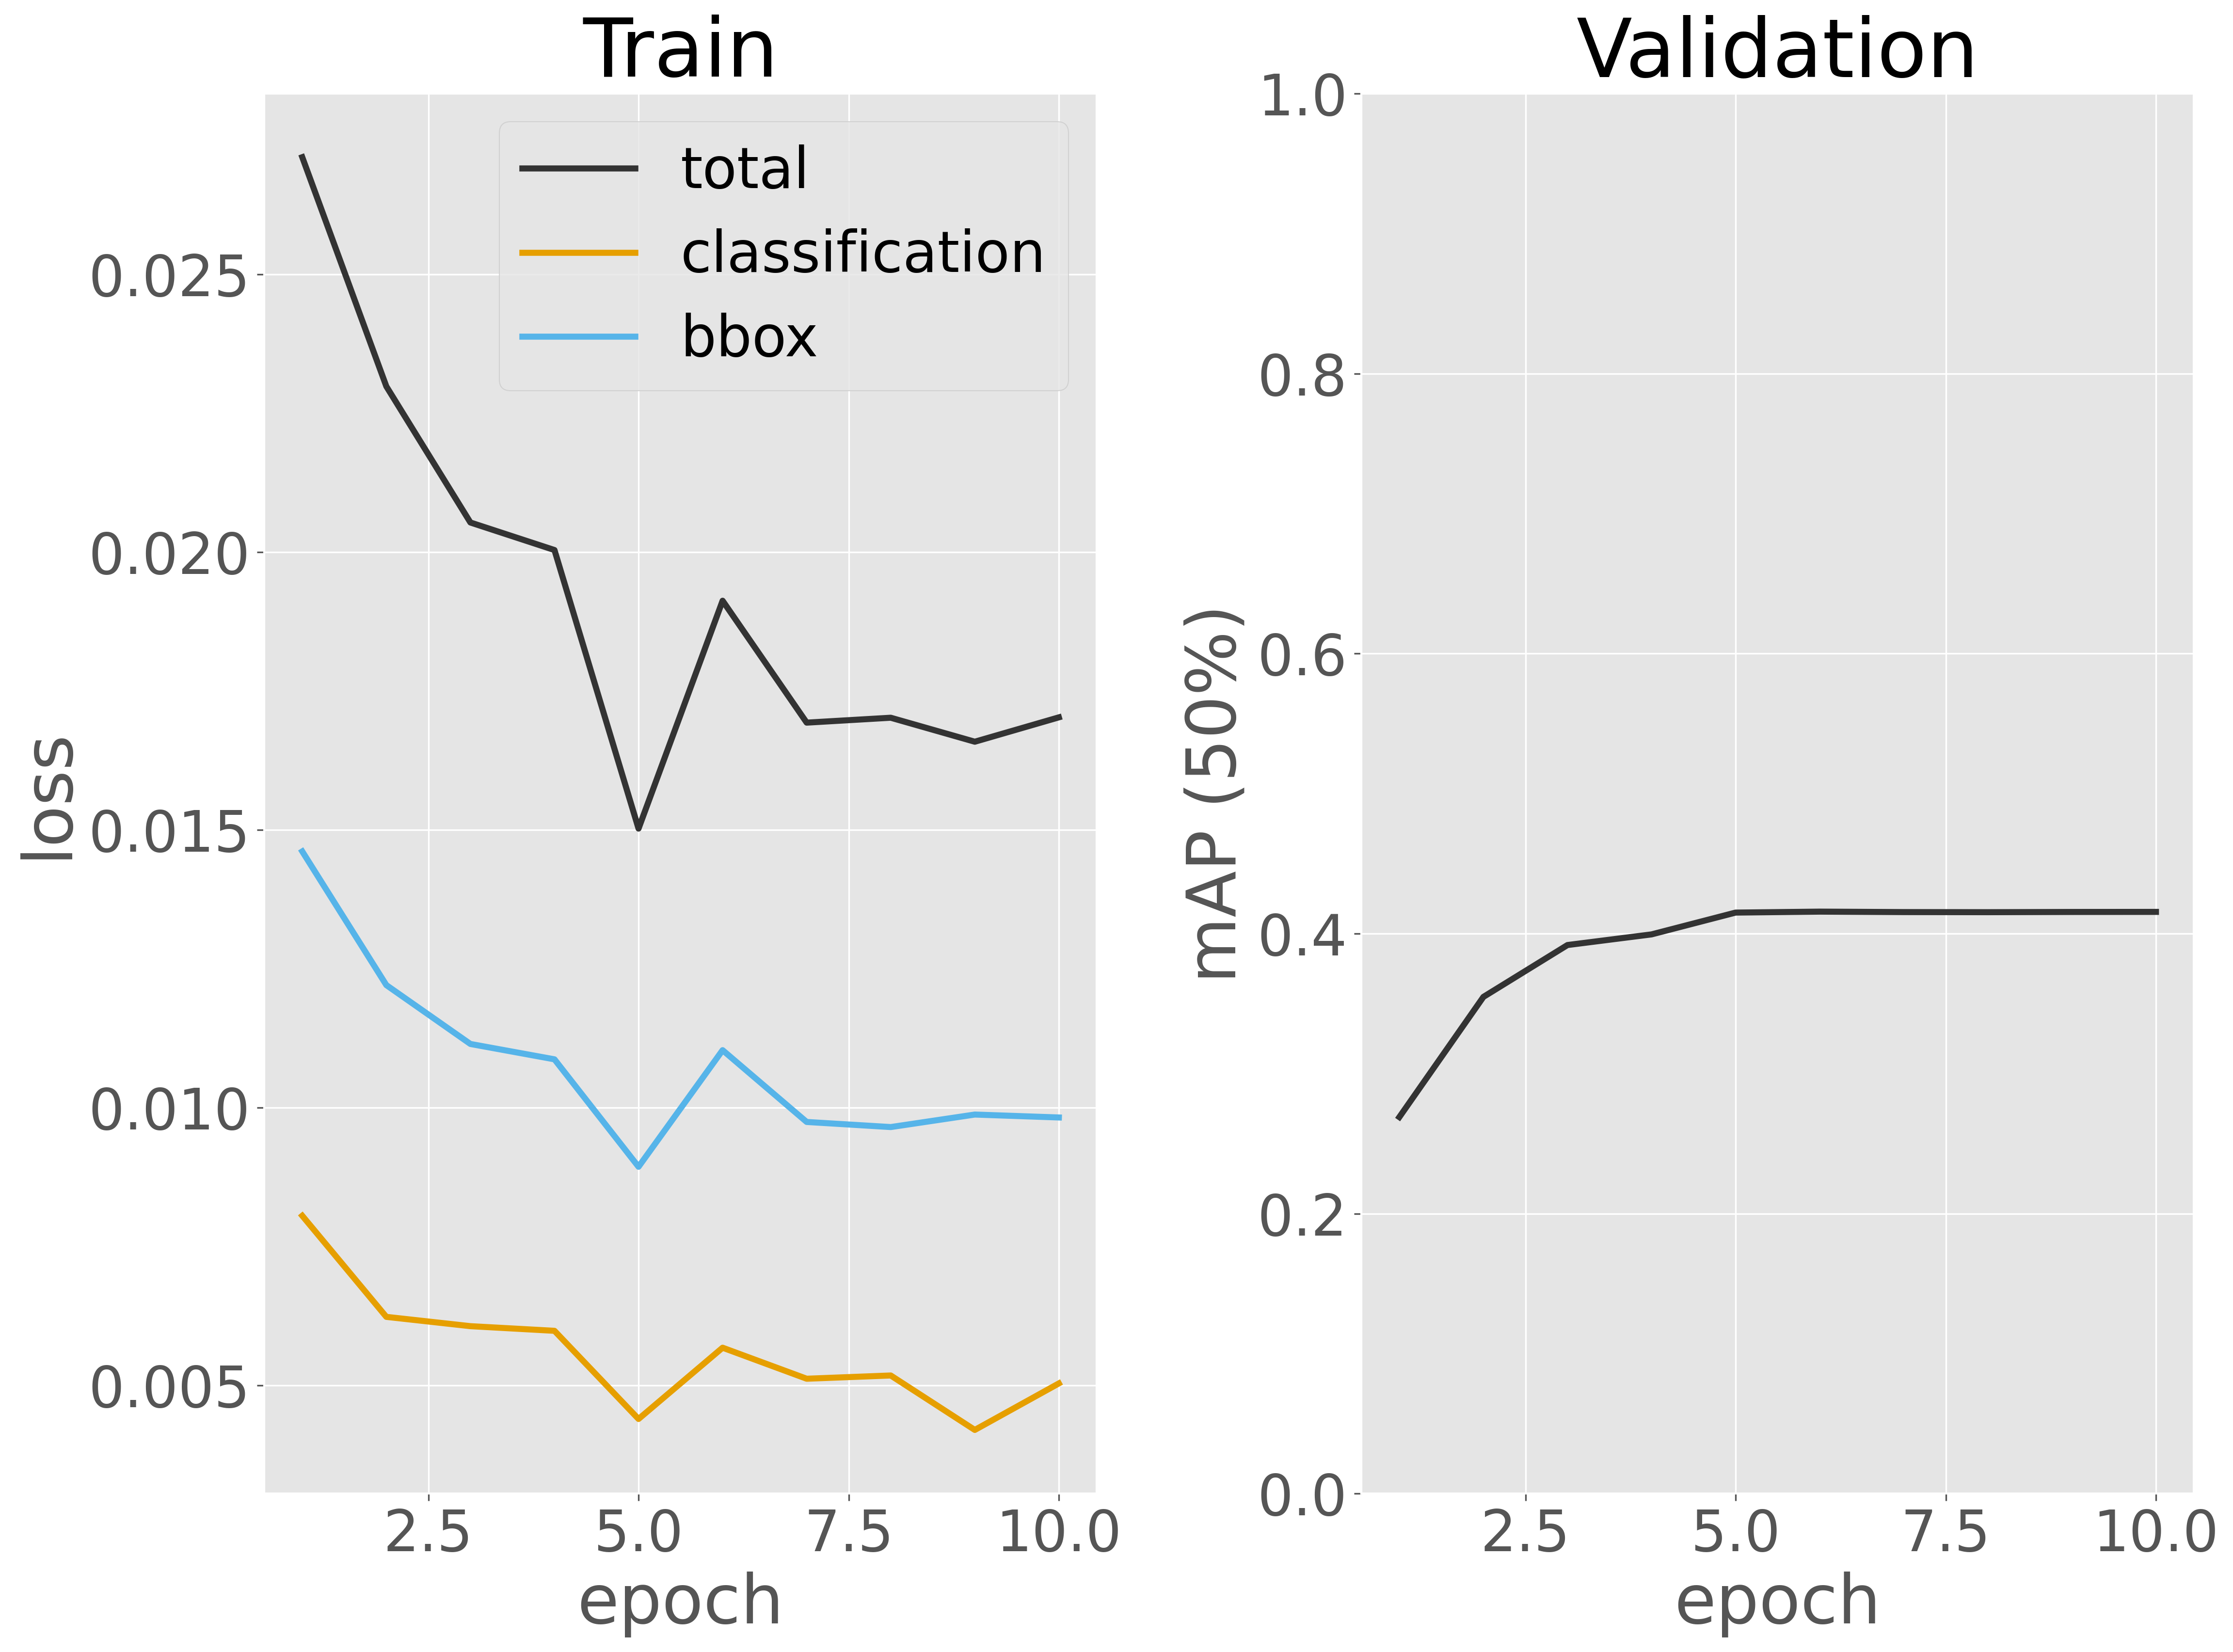

In [9]:
metric_dict = pd.DataFrame(metric_dict)

fig, ax = plt.subplots(1, 2)
ax[0].plot(metric_dict['epoch'], metric_dict['train_loss_total'], label='total')
ax[0].plot(metric_dict['epoch'], metric_dict['train_loss_classifier'], label='classification')
ax[0].plot(metric_dict['epoch'], metric_dict['train_loss_box_reg'], label='bbox')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].set_title('Train')
ax[0].legend()
ax[1].plot(metric_dict['epoch'], metric_dict['map_50'])
ax[1].set_ylim(0, 1)
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('mAP (50%)')
ax[1].set_title('Validation')
plt.tight_layout()
fig.show()

In [10]:
glue('valid_map', metric_dict['map_50'].iloc[5:].mean(), display=False)

可視化の結果から、エポック数が増えるにつれて訓練データに対する損失が継続的に減少していることが確認できます。10 エポック目においても訓練損失が減少し続ける傾向がまだ見られます。一方、検証データに対する検出性能（mAP 50%）は、5 エポックを過ぎたあたりでほぼ収束しているようです。ただし、値が {glue:text}`valid_map:.3f` と低く、十分とはいえません。このため、訓練エポック数をさらに増やして損失や検証性能の推移を詳しく観察するか、必要に応じてデータを増やして再訓練することが考えられます。ただし、本節では、時間の制約があるため、訓練はここで終了します。

次に、この手順を SSD や YOLO など、他の深層ニューラルネットワークのアーキテクチャに適用し、それぞれの検証性能を比較します。この比較により、データセットに最も適したアーキテクチャを選定します。ただし、本節では時間の関係で他のアーキテクチャを構築せず、上で構築した Faster R-CNN を最適なアーキテクチャとして扱い、次のステップに進みます。

次のステップでは、訓練サブセットと検証サブセットを統合し、最適と判断したアーキテクチャを最初から訓練します。

モデル選択のために行われた訓練と検証の結果から、数エポックの訓練だけでも十分に高い予測性能を獲得できたことがわかったので、ここでは訓練サブセットと検証サブセットを統合したデータに対して 5 エポックだけ訓練させます。

In [11]:
# model
model = fasterrcnn(num_classes=1)
model.to(device)

# training parameters
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# training data
train_loader = torch.utils.data.DataLoader(
                            CocoDataset('gwhd', 'gwhd/trainvalid.json'),
                            batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

# training
num_epochs = 5
metric_dict = []
for epoch in range(num_epochs):
    model.train()
    epoch_loss_dict = {}
    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        batch_loss_dict = model(images, targets)
        batch_tol_loss = 0
        for loss_type, loss_val in batch_loss_dict.items():
            batch_tol_loss += loss_val
            if loss_type in epoch_loss_dict:
                epoch_loss_dict[f'train_{loss_type}'] += loss_val.item()
            else:
                epoch_loss_dict[f'train_{loss_type}'] = loss_val.item()
        optimizer.zero_grad()
        batch_tol_loss.backward()
        optimizer.step()
    lr_scheduler.step()

    # record training loss
    epoch_loss_dict['train_loss_total'] = sum(epoch_loss_dict.values())
    metric_dict.append({k: v / len(train_loader) for k, v in epoch_loss_dict.items()})
    metric_dict[-1]['epoch'] = epoch + 1
    print(metric_dict[-1])



loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
{'train_loss_classifier': 0.0026550070444742837, 'train_loss_box_reg': 0.00626326322555542, 'train_loss_objectness': 0.0007960924009482066, 'train_loss_rpn_box_reg': 0.0009493589401245117, 'train_loss_total': 0.010663721611102421, 'epoch': 1}
{'train_loss_classifier': 0.003302829662958781, 'train_loss_box_reg': 0.0068442400296529135, 'train_loss_objectness': 0.0006440661350886027, 'train_loss_rpn_box_reg': 0.0010030893484751383, 'train_loss_total': 0.011794225176175436, 'epoch': 2}
{'train_loss_classifier': 0.004061779975891113, 'train_loss_box_reg': 0.007083093325297038, 'train_loss_objectness': 0.0009073551495869954, 'train_loss_rpn_box_reg': 0.0012336663405100505, 'train_loss_total': 0.013285894791285197, 'epoch': 3}
{'train_loss_classifier': 0.0018915977080663044, 'train_loss_box_reg': 0.004415913820266724, 'train_loss_objectness': 0.00031236531833807627, 'train_loss_rpn_box_reg': 0.00245061139265696

訓練が完了したら、訓練済みモデルの重みをファイルに保存します。

In [12]:
model.to('cpu')
torch.save(model.state_dict(), 'gwhd.pth')

## モデル評価

最適なモデルが得られたら、次にテストデータを用いて詳細な評価を行います。ここでは、物体検出で一般的に用いられる評価指標である mAP を計算し、さらに各画像に対して予測された穂の数と実際の穂の数も記録します。なお、予測スコアが 0.5 を超える領域を予測領域として、閾値を設定しています。

In [22]:
test_loader = torch.utils.data.DataLoader(
                    CocoDataset('gwhd', 'gwhd/test.json'),
                    batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

model = fasterrcnn(num_classes=1, weights='gwhd.pth')
model.to(device)
model.eval()

n_gt = []
n_predicted = []
metric = torchmetrics.detection.mean_ap.MeanAveragePrecision()
with torch.no_grad():
    for images, targets in test_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        outputs = model(images)

        for target, output in zip(targets, outputs):
            n_gt.append(len(target['labels']))
            _n = 0
            for score in output['scores']:
                if score > 0.5:
                    _n += 1
            n_predicted.append(_n)
        
        metric.update(outputs, targets)

metrics = {}
for k, v in metric.compute().items():
    metrics[k] = v.cpu().detach().numpy().tolist()

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [23]:
metrics

{'map': 0.22903168201446533,
 'map_50': 0.4438343644142151,
 'map_75': 0.212175190448761,
 'map_small': 0.08966253697872162,
 'map_medium': 0.4586022198200226,
 'map_large': 0.4719752073287964,
 'mar_1': 0.008168082684278488,
 'mar_10': 0.07268649339675903,
 'mar_100': 0.26428234577178955,
 'mar_small': 0.10535714030265808,
 'mar_medium': 0.5285714268684387,
 'mar_large': 0.5416452288627625,
 'map_per_class': -1.0,
 'mar_100_per_class': -1.0,
 'classes': [0, 1]}

ここで出力される指標について、`map` から始まる指標は [mAP](metrics) を表し、`mar` から始まる指標は mean average recall（平均再現率）を示します。`mar` はすべてのクラスに対する再現率を計算し、それらの平均を求めたものです。mAR 1 は、各画像に対してモデルが検出した物体のうち、最も信頼度の高い物体だけを利用して計算した再現率を表します。同様に、mAR 10 および mAR 100 は、モデルが検出した物体のうち、信頼度の高い 10 および 100 物体を利用して計算した再現率を表しています。

次に、予測した穂の数と実際の穂の数を散布図で可視化して評価します。

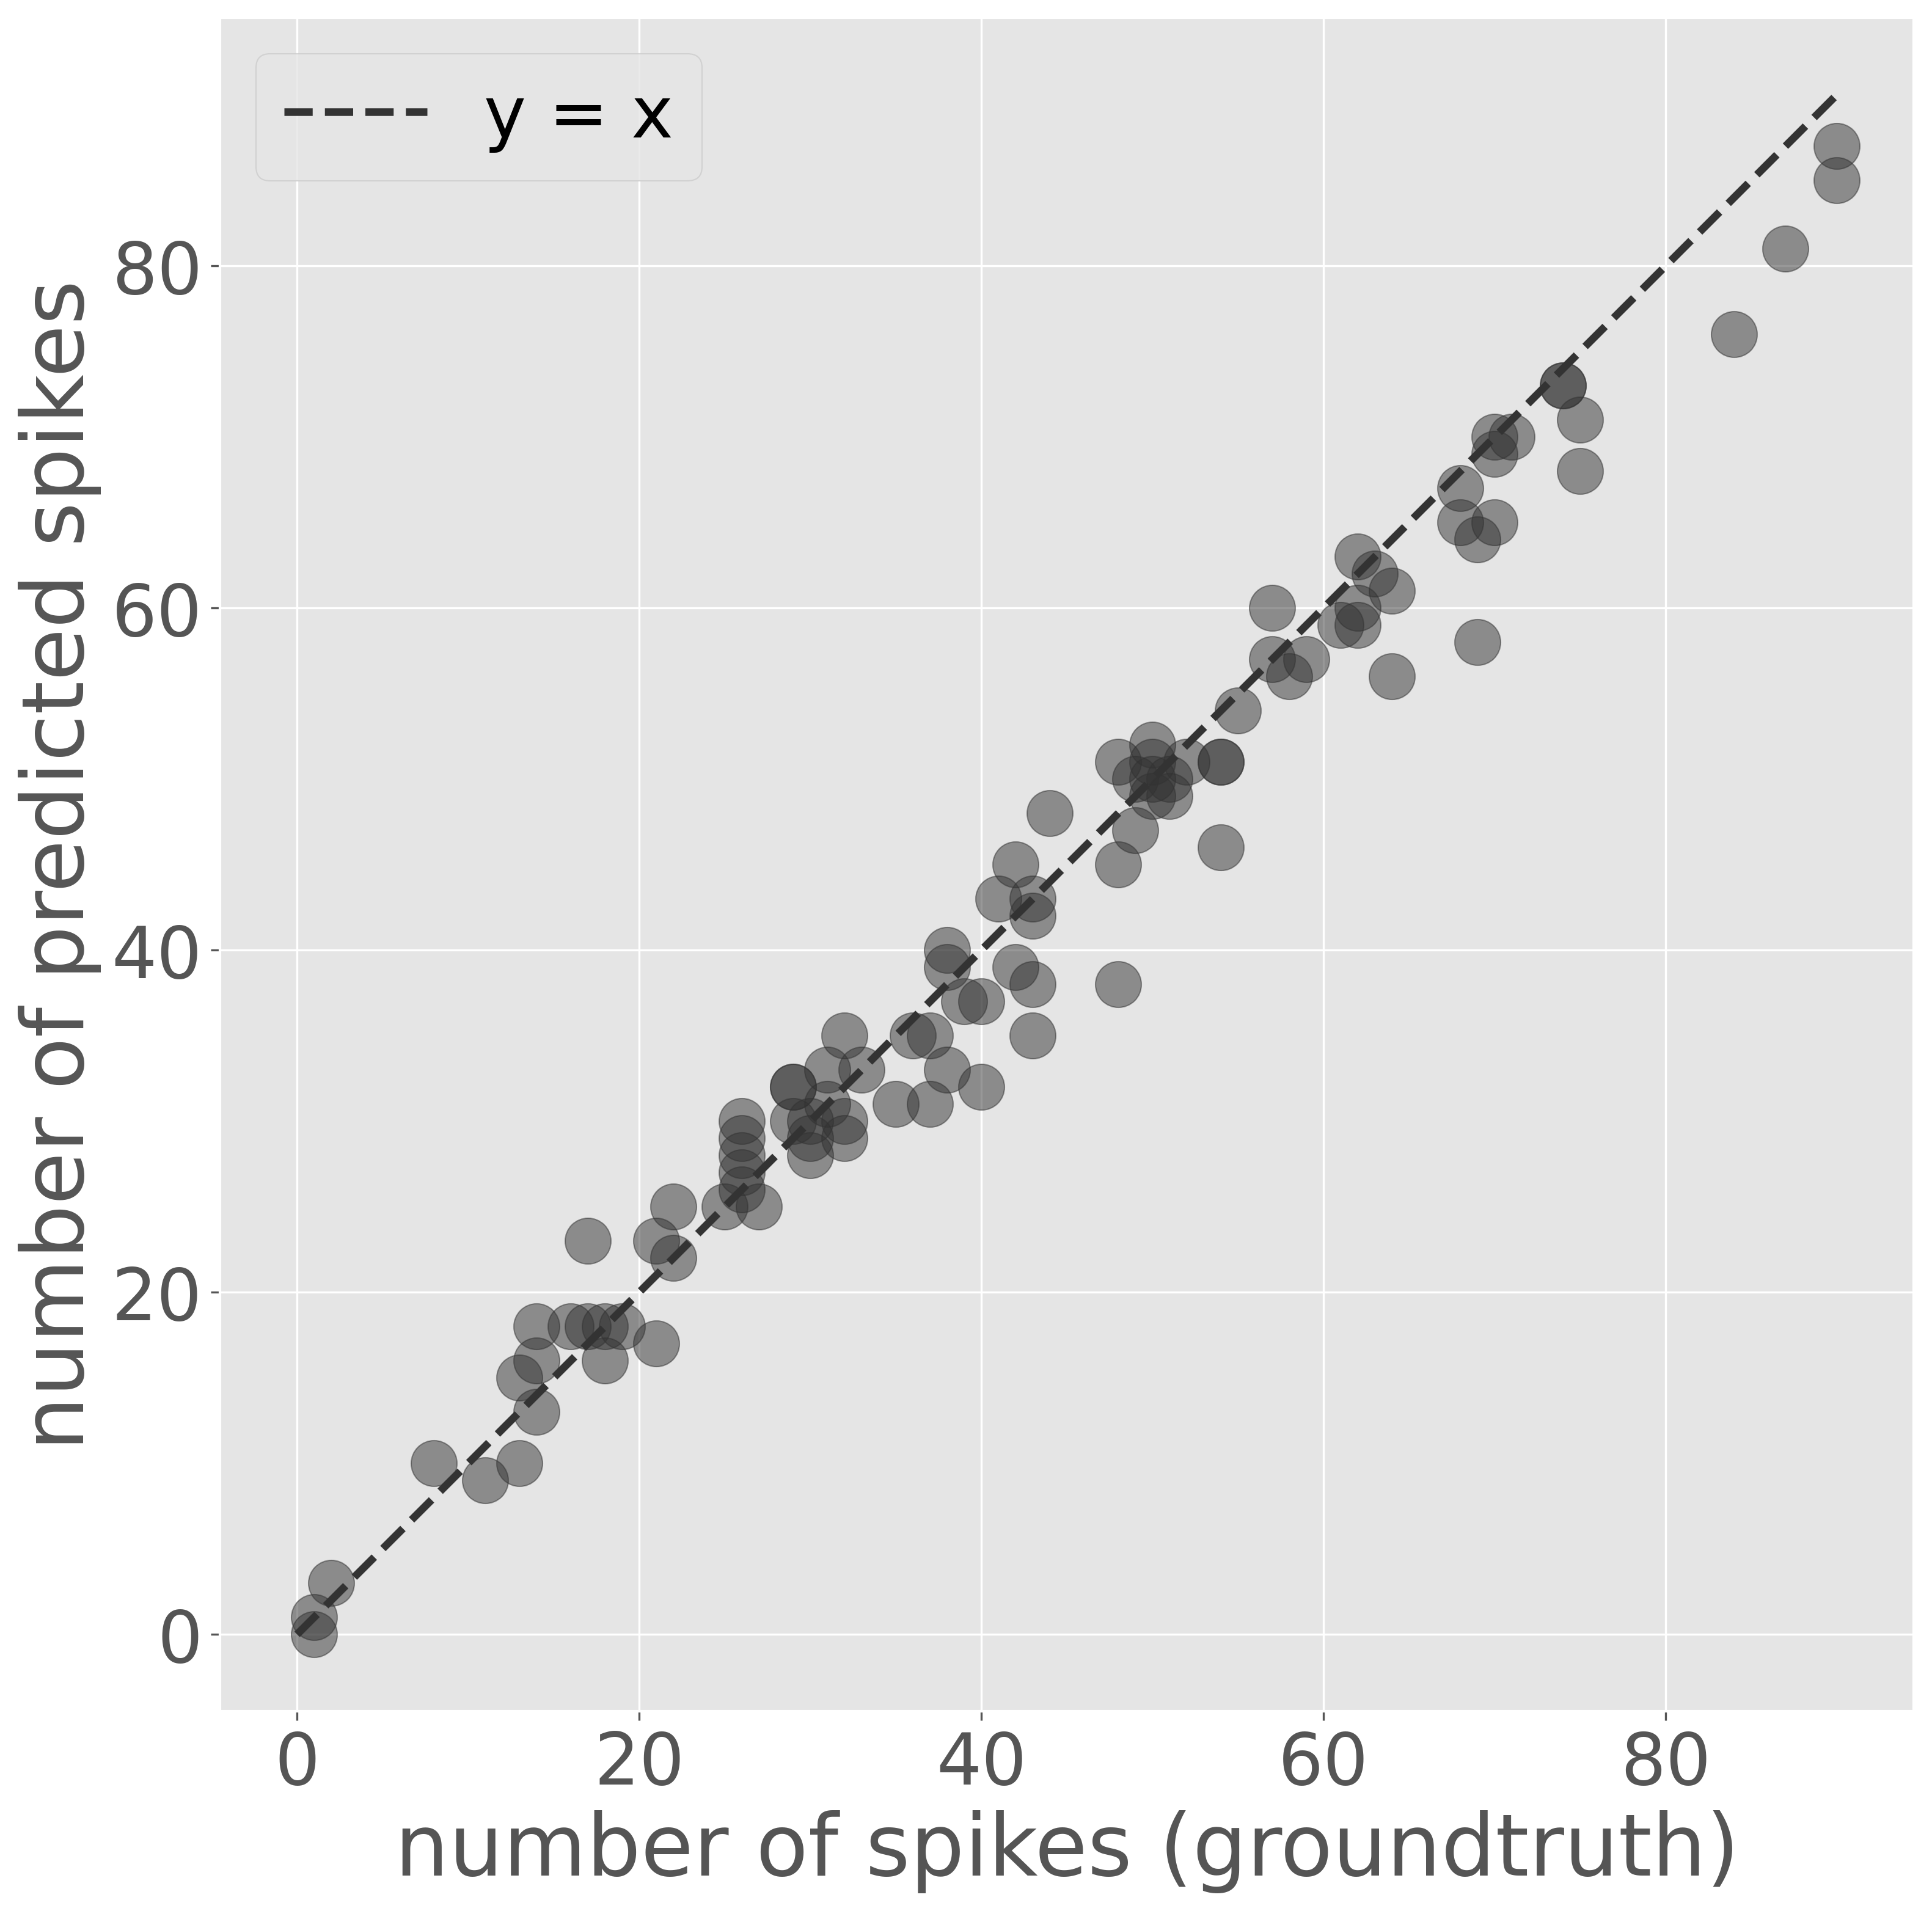

In [27]:
fig, ax = plt.subplots()
ax.scatter(n_gt, n_predicted, alpha=0.5)

mn = min(min(n_gt), min(n_predicted))
mx = max(max(n_gt), max(n_predicted))
ax.plot([mn, mx], [mn, mx], '--', label='y = x')

ax.set_xlabel('number of spikes (groundtruth)')
ax.set_ylabel('number of predicted spikes')
ax.set_aspect('equal')
ax.legend()
fig.show()

可視化の結果、予測数と実際の数が完全に一致する画像はほとんどありませんでしたが、ほとんどの画像においてほぼ正確に穂を検出できたことが確認できました。

## 推論

推論時にも、訓練時と同じように torchvision モジュールからアーキテクチャを呼び出し、出力層のクラス数を設定します。その後、`load_state_dict` メソッドを使って、訓練済みの重みファイルをモデルにロードします。これらの操作はすべて `fasterrcnn` 関数で定義されているので、その関数を利用します。

In [ ]:
model = fasterrcnn(num_classes=1, weights='gwhd.pth')
model.to(device)
model.eval()

このモデルを利用して推論を行います。まず、1 枚の画像を指定し、PIL モジュールを用いて画像を開き、テンソル形式に変換した後、モデルに入力します。モデルは予測結果としてバウンディングボックスの座標（`bboxes`）、分類ラベル（`labels`）、および信頼スコア（`scores`）を出力します。ただし、信頼スコアが 0.5 未満のバウンディングボックスは採用せず、信頼スコアが高い結果のみを選択して利用します。

In [ ]:
threshold = 0.5
image_path = 'gwhd/images/fda86ae9a.jpg'

image = PIL.Image.open(image_path).convert('RGB')
input_tensor = torchvision.transforms.functional.to_tensor(image).unsqueeze(0).to(device)
    
with torch.no_grad():
    predictions = model(input_tensor)[0]
    
bboxes = predictions['boxes'][predictions['scores'] > threshold]
labels = predictions['labels'][predictions['scores'] > threshold]
scores = predictions['scores'][predictions['scores'] > threshold]

検出されたオブジェクトのバウンディングボックスを入力画像に描画します。その後、PIL および matplotlib ライブラリを使用して、画像とその検出結果を可視化します。

In [ ]:
draw = PIL.ImageDraw.Draw(image)
for bbox, label, score in zip(bboxes, labels, scores):
    x1, y1, x2, y2 = bbox
    draw.rectangle(((x1, y1), (x2, y2)), outline="blue", width=3)
    draw.text((x1, y1 - 10), f"{label.item()} ({score:.2f})", fill="blue")
    
fig = plt.figure()
ax = fig.add_subplot()
ax.imshow(image)
ax.axis('off')
fig.show()

次にこのモデルにもう一枚の画像を入力し、その推論結果を見てみましょう。

In [ ]:
threshold = 0.5
image_path = 'gwhd/images/cb34f7509.jpg'

image = PIL.Image.open(image_path).convert('RGB')
input_tensor = torchvision.transforms.functional.to_tensor(image).unsqueeze(0).to(device)
    
with torch.no_grad():
    predictions = model(input_tensor)[0]
    
bboxes = predictions['boxes'][predictions['scores'] > threshold]
labels = predictions['labels'][predictions['scores'] > threshold]
scores = predictions['scores'][predictions['scores'] > threshold]

draw = PIL.ImageDraw.Draw(image)
for bbox, label, score in zip(bboxes, labels, scores):
    x1, y1, x2, y2 = bbox
    draw.rectangle(((x1, y1), (x2, y2)), outline="blue", width=3)
    draw.text((x1, y1 - 10), f"{label.item()} ({score:.2f})", fill="blue")
    
fig = plt.figure()
ax = fig.add_subplot()
ax.imshow(image)
ax.axis('off')
fig.show()

In [ ]:
threshold = 0.5
image_path = 'gwhd/images/d3b3b5628.jpg'

image = PIL.Image.open(image_path).convert('RGB')
input_tensor = torchvision.transforms.functional.to_tensor(image).unsqueeze(0).to(device)
    
with torch.no_grad():
    predictions = model(input_tensor)[0]
    
bboxes = predictions['boxes'][predictions['scores'] > threshold]
labels = predictions['labels'][predictions['scores'] > threshold]
scores = predictions['scores'][predictions['scores'] > threshold]

draw = PIL.ImageDraw.Draw(image)
for bbox, label, score in zip(bboxes, labels, scores):
    x1, y1, x2, y2 = bbox
    draw.rectangle(((x1, y1), (x2, y2)), outline="blue", width=3)
    draw.text((x1, y1 - 10), f"{label.item()} ({score:.2f})", fill="blue")
    
fig = plt.figure()
ax = fig.add_subplot()
ax.imshow(image)
ax.axis('off')
fig.show()